In [4]:
import re
import os
#from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import word2vec
from gensim.models.word2vec import Text8Corpus
import gensim
import numpy as np

In [14]:
def cleaner(i, stops, lemmatizer):
    # clean and tokenize document string
    #convert to all lowercase
    raw = i.lower()
    #remove non-letter chars
    letters_only = re.sub("[^a-zA-Z]", " ", raw)
    #tokenize words
    tokens = letters_only.split()
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stops]
    # stem tokens
    #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    #lemmatize tokens
    lemmad_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
    
    return lemmad_tokens

In [15]:
# Create a list of stop words, then convert to set for quicker use
stops = set(stopwords.words("english"))
# Create p_stemmer of class PorterStemmer
#p_stemmer = PorterStemmer()
# Create a lemmatizer
lemmatizer=WordNetLemmatizer()

In [16]:
f=open("Data/comments.txt",'r')
docSet = f.readlines()
f.close()

In [17]:
texts = []
for i in docSet:
    # add tokens to list
    texts.append(cleaner(i,stops,lemmatizer))

In [18]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [19]:
tfModel=models.TfidfModel(corpus)
corpus_tfidf = tfModel[corpus]

In [20]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100, onepass=False) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [21]:
lsi.print_topics(2)

[(0,
  u'0.465*"great" + 0.442*"car" + 0.366*"love" + 0.239*"good" + 0.211*"vehicle" + 0.195*"everything" + 0.169*"like" + 0.158*"mileage" + 0.158*"gas" + 0.152*"nissan"'),
 (1,
  u'-0.778*"nothing" + -0.462*"everything" + -0.211*"love" + 0.206*"great" + 0.143*"mileage" + 0.139*"gas" + 0.124*"good" + 0.083*"car" + 0.058*"look" + 0.054*"ride"')]

In [22]:
a=lsi.show_topic(1)
print(a[1][0])

everything


In [23]:
model = gensim.models.word2vec.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#model = word2vec.Word2Vec(sentences, size=200)

In [25]:
sum=0
vec=np.zeros(300)
for i in range(len(a)):
    vec+=a[i][1]*np.array(model[a[i][0]])
    sum+=a[i][1]
    
vec=vec/sum
print(vec)
model.similar_by_vector(vec,3)

[ 0.24116144 -0.20068301  0.03322839 -0.14728838 -0.32616266  0.17889958
  0.52310821 -0.32182184 -0.17271934 -0.04458753 -0.0855335  -0.32651669
 -0.20223953  0.16263682 -0.53433514  0.2814556   0.15726198  0.15626037
  0.43755337 -0.05068692 -0.08476238 -0.00896305  0.10040534 -0.54710964
  0.13502759  0.14631802  0.27849211  0.01322788  0.03445182 -0.08657685
 -0.03758958  0.13395498 -0.10810325 -0.1599589   0.20443063  0.27917138
  0.39309905  0.00473013 -0.02000245 -0.17506525  0.05582348 -0.10948832
  0.2357278  -0.15301168  0.05208065 -0.1815261  -0.10703264  0.08834465
 -0.12330999  0.12141565 -0.01705434  0.07095723 -0.05915609 -0.32739852
  0.04797697  0.02269261 -0.25529328 -0.58476138 -0.30593175 -0.24502892
  0.20490531  0.3172107   0.54685714  0.12602885  0.01772111 -0.06128491
  0.11094588 -0.15856215 -0.14806649  0.13306347  0.22610113 -0.02712881
  0.20185883  0.12687518 -0.26353703 -0.27834979  0.08717978 -0.33937667
  0.33259695  0.18125825 -0.09502249 -0.16757321  0

[(u'nothing', 0.85944664478302),
 (u'everything', 0.7460726499557495),
 (u'anything', 0.7308634519577026)]

In [ ]:
lsi.save("lsi.model")
tfModel.save("tfidf.model")

In [ ]:
dictionary.save("lsaDictionary.dict")

In [ ]:
lsi=models.LsiModel.load('lsi.model', mmap='r')
#tfModel=models.TfidfModel.load("tfidf.model")

In [ ]:
index.save('similarity.index')

In [9]:
index = gensim.similarities.docsim.Similarity('/tmp/index', lsi[tfModel[corpus]], num_features=500)

/usr/lib/python2.7/dist-packages/scipy/sparse/compressed.py:122: UserWarning: indices array has non-integer dtype (float64)
  % self.indices.dtype.name)


In [10]:
index.num_best = 10
index[query]

NameError: name 'query' is not defined

In [ ]:
print([[docSet[i],j] for i, j in index[query]])

In [89]:
import numpy as np
data=lsi[tfModel[corpus[15000:20000]]]

In [76]:
print(data)

In [90]:
# Convert lsi corpus to numpy matrix
npdata = np.transpose(gensim.matutils.corpus2dense(data, num_terms=100))

In [91]:
# Dimension reduction to aid tSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pcaData=pca.fit_transform(npdata)

In [92]:
pcaData.shape

(5000, 50)

In [93]:
#Reduce to 2D dataset for easy graphing
from sklearn.manifold import TSNE
model = TSNE()
tsneData=model.fit_transform(pcaData)

In [15]:
%pylab inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
import matplotlib.pyplot as plt

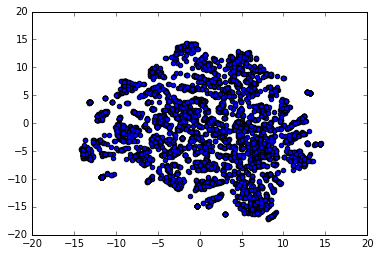

In [94]:
plt.scatter(tsneData[:,0],tsneData[:,1])

In [68]:
tsneData.shape

(3000, 2)

In [71]:
np.argmin(tsneData[:,0])

2557

In [72]:
print(texts[np.argmin(tsneData[:,0])])

['truly', 'beautiful', 'car', 'great', 'experience']
